In [118]:
from functools import reduce
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from ta import add_all_ta_features
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.options.mode.chained_assignment = None
np.seterr(divide="ignore", invalid="ignore")
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_parquet("../data/compustat_ibes_raw_alpha.1.parquet")

## Mooomentums

In [3]:
def extreme(df):
    """Retain the 20% values that are the smallest and the 20% that are the largest."""
    top = df.y.quantile(0.8)
    low = df.y.quantile(0.2)
    return df[(df.y < low) | (df.y > top)]

In [116]:
def threshold(y):
    thres = 0.1
    y_0 = np.where(y <= -thres, -1, y)
    y_1 = np.where((y < thres) & (y > -thres), 0, y_0)
    y_2 = np.where(y >= thres, 1, y_1)
    return y_2

In [89]:
def r2(y_true, y_pred):
    r2 = 1 - np.sum((y_true - y_pred) ** 2)/np.sum(y_true ** 2)
    return r2

r2_score = make_scorer(r2)

In [83]:
def mooom(df):
    """
    Mooom is a strategy that heavily relies on momentum.
    It enriches dataframe with simple momentum and industrial momentum factors. 
    Returns will be substracted by a cross-sectional median.
    """
    df_mom = df[["classification",
                 "mcap",
                 "act",
                 "ceq",
                 "cogs",
                 "lct",
                 "nicon",
                 "revt",
                 "xrd",
                 "prccd",
                 "close"]]
    df_mom["profitability_roe"]=df_mom.nicon / df_mom.ceq
    df_mom["intangible_rdm"] = df_mom.xrd / df_mom.mcap
    df_mom["liquid_cur"] = df_mom.act / df_mom.lct
    df_mom["market_pe"] = df_mom.mcap / (df_mom.nicon * 10 ** 6)
    df_mom["market_mb"] = df_mom.mcap / (df_mom.ceq * 10 ** 6)
    df_mom["52wk_high"] = df_mom.close.groupby("gvkey").transform(lambda x: np.log(x) - np.log(x.rolling(12, min_periods=1).max()))
    df_mom["mom_12m"] = df_mom.close.groupby("gvkey").transform(lambda x: np.log(x.shift(2))-np.log(x.shift(13)))
    df_mom["mom_6m"] = df_mom.close.groupby("gvkey").transform(lambda x: np.log(x).shift(2) - np.log(x.shift(7)))
    df_mom["mom_1m"] = df_mom.close.groupby("gvkey").transform(lambda x: np.log(x) - np.log(x.shift(1)))
    df_mom["ind_mom_12m"] = df_mom.groupby(["date", "classification"]).mom_12m.transform("mean")
    df_mom["ind_mom_6m"] = df_mom.groupby(["date", "classification"]).mom_6m.transform("mean")
    df_mom["ind_mom_1m"] = df_mom.groupby(["date", "classification"]).mom_1m.transform("mean")
    df_mom["log_return"] = df_mom.close.groupby("gvkey").transform(lambda x: np.log(x.shift(-3)) - np.log(x))
    df_mom["y"] = df_mom.groupby("date").log_return.transform(lambda x: (x - x.median()).clip(-1,1))
    return df_mom.loc[df.prccd > 5, ["mcap",
                                     "profitability_roe",
                                     "intangible_rdm",
                                     "liquid_cur",
                                     "market_mb",
                                     "market_pe",
                                     "52wk_high",
                                     "mom_12m",
                                     "mom_6m",
                                     "mom_1m",
                                     "ind_mom_12m",
                                     "ind_mom_6m",
                                     "ind_mom_1m",
                                     "y"]].dropna()

In [125]:
df_mom = mooom(df)
# df_train = df_mom.xs(slice("2002-01-01", "2012-01-01"), level="date", drop_level=False)
df_train = df_mom.xs(slice("2002-01-01", "2012-01-01"), level="date", drop_level=False).groupby("date").apply(extreme)
df_test = df_mom.xs(slice("2012-01-01", "2016-01-01"), level="date", drop_level=False)
X_train = df_train.drop(["y"], axis=1).to_numpy()
y_train = df_train["y"].to_numpy()
X_test = df_test.drop(["y"], axis=1).to_numpy()
y_test = df_test["y"].to_numpy()

In [126]:
xgb_reg = XGBRegressor(n_estimators=100, max_depth=3, n_jobs=-1)
xgb_fit = xgb_reg.fit(X_train, y_train)
train_score = r2_score(xgb_reg, X_train, y_train)
test_score = r2_score(xgb_reg, X_test, y_test)
print(f"R2 on training set: {train_score}\nR2 on test set: {test_score}")

R2 on training set: 0.1494156124487761
R2 on test set: -0.02287041306154558


              precision    recall  f1-score   support

        sell       0.24      0.47      0.32      7102
        hold       0.00      0.00      0.00     26866
         buy       0.22      0.72      0.34      8817

    accuracy                           0.23     42785
   macro avg       0.15      0.40      0.22     42785
weighted avg       0.09      0.23      0.12     42785



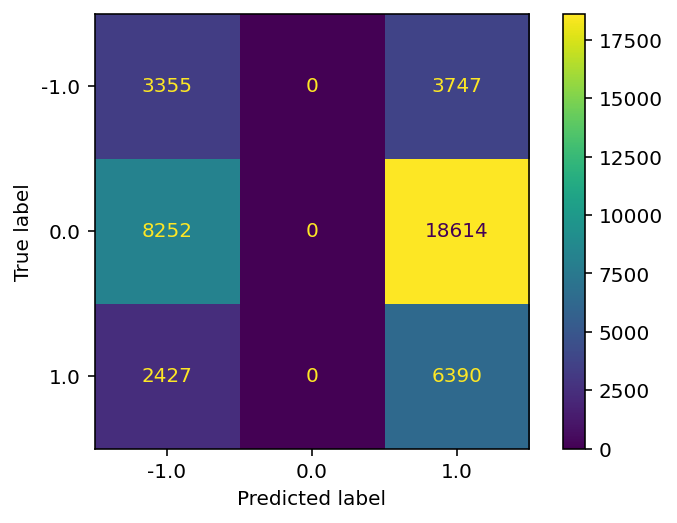

In [127]:
xgb_clf = XGBClassifier(n_estimators=100, max_depth=3, n_jobs=-1, eval_metric='logloss')
y_train_thres = threshold(y_train)
y_test_thres = threshold(y_test)
xgb_fit = xgb_clf.fit(X_train, y_train_thres)
plot_confusion_matrix(xgb_clf, X_test, y_test_thres)
print(classification_report(y_test_thres, xgb_fit.predict(X_test), target_names=["sell", "hold", "buy"]))

In [154]:
# backtest
# every stock invest 100
# every day invest top 10 predicted best performing stocks
# collect return 7 days after
# y_position = y_pred.grouby("date").head(10)
# y_return = y_position * y_test
